# Rules

**Dates**: 23.12.2024 - 29.12.2024

**Deadline**: 29.12.2024 23:59

**Submission after deadline**: NOT POSSIBLE


For each task you'll get a certain ammount of points (indicated in brackets next to the task). The maximum grade for the work is 10 points.

* **Tasks, where you should write code**, are marked with 🐍 (snake emoji).

* **Questions, where you should write your comments**, are marked with ❓ (question emoji).

You'll also see "assert" code, this code is ought to help you: if you're doing everything right - the code won't show AssertionError error.

**Disclaimer**: the exam must be completed independently. "Very similar" solutions are considered plagiarism and all students involved (including those from whom the work was copied) cannot receive more than 0 points for it.


# Preparations

Note, that you should import additional libraries and modules for the solution.

In [3]:
# Handling data
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import plotly.express as px

# Tests
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss

# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL as STL_decomp
from statsmodels.tsa.seasonal import MSTL as MSTL_decomp

# Prophet model
import prophet as fp

# Tuning
import itertools

import warnings
warnings.filterwarnings("ignore")

In [4]:
!pip install pmdarima

# auto ARIMA
from pmdarima import auto_arima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.7 MB/s eta 0:00:00


In [5]:
!pip install statsforecast

# MSTL
from statsforecast import StatsForecast
from statsforecast.models import (
    MSTL
  )

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 10.1 MB/s eta 0:00:00


In [6]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [7]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [8]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


# Problem definition

You will work on forecasting metrics of *BookBnb*, a short-term rental platform, which is loved by travelers by its services and quality of properties. You will forecast metric of **views** for listings (=properties) from *Kaliningrad*, listed withing the platform.

The **views** metric represents the number of times a property listing is viewed by users on the platform. It serves as an indicator of interest or demand for a particular property or destination. This metric is crucial for understanding user engagement, the attractiveness of listings and overall platform activity. Thus, **views** in Kaliningrad reflect the level of interest in this region, making it a key metric for evaluating its popularity and potential for further investment.

The primary objective is to evaluate the popularity of Kaliningrad as a destination on the platform and determine whether it's worth investing in advertising properties in this region. Your forecast will guide BookBnb in making strategic decisions about resource allocation and marketing campaigns to drive growth and enhance user experience.

Your goal is to build a reliable forecast for the next year and prove that the company can trust it. This forecast will serve as a foundation for making informed decisions in the competitive rental market. Good luck! 🚀

Note the forecast horizon: your final task is to forecast one future year.

In [9]:
FORECAST_HORIZON = 365

# Data

You can download the dataset *exam_views_kgd.csv* with time series for *views* from the [link](https://drive.google.com/file/d/1XRh0JKvFGtNjOJXG4_qZBDWX9R5FXldb/view?usp=sharing).

The dataset includes historical data **from the start of 2019 to the end of 2022** (imagine it's 2022 now :D).

**Columns:**

* *region* - region, where properties are present, in this dataset only "Kaliningrad" is present;

* *dt* - dates, daily, no absent dates;

* *metric* - name of the metric, in this dataset only "views" is present;

* *value* - value of the metric.

In [10]:
df = pd.read_csv('exam_views_kgd.csv', sep=';', parse_dates=['dt'])
df

,region,dt,metric,value
0,Kaliningrad,2019-01-01,views,26011.0
1,Kaliningrad,2019-01-02,views,23158.0
2,Kaliningrad,2019-01-03,views,23413.0
3,Kaliningrad,2019-01-04,views,22534.0
4,Kaliningrad,2019-01-05,views,21431.0
...,...,...,...,...
1456,Kaliningrad,2022-12-27,views,23796.0
1457,Kaliningrad,2022-12-28,views,22762.0
1458,Kaliningrad,2022-12-29,views,20338.0
1459,Kaliningrad,2022-12-30,views,10723.0


In [102]:
df.head(10)

,region,ds,metric,y
0,Kaliningrad,2019-01-01,views,26011.0
1,Kaliningrad,2019-01-02,views,23158.0
2,Kaliningrad,2019-01-03,views,23413.0
3,Kaliningrad,2019-01-04,views,22534.0
4,Kaliningrad,2019-01-05,views,21431.0
5,Kaliningrad,2019-01-06,views,23524.0
6,Kaliningrad,2019-01-07,views,25079.0
7,Kaliningrad,2019-01-08,views,25417.0
8,Kaliningrad,2019-01-09,views,25330.0
9,Kaliningrad,2019-01-10,views,24495.0


Let's plot the time series.

In [11]:
fig = px.line(title="BookBnb views for listings from Kaliningrad, daily")
fig.add_scatter(x=df.dt, y=df['value'], mode='lines')

fig.update_layout(template='plotly_white', width=10000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="views")
fig.show()

For further work columns should be renamed.

In [12]:
df.columns = ['region', 'ds', 'metric', 'y']

df

,region,ds,metric,y
0,Kaliningrad,2019-01-01,views,26011.0
1,Kaliningrad,2019-01-02,views,23158.0
2,Kaliningrad,2019-01-03,views,23413.0
3,Kaliningrad,2019-01-04,views,22534.0
4,Kaliningrad,2019-01-05,views,21431.0
...,...,...,...,...
1456,Kaliningrad,2022-12-27,views,23796.0
1457,Kaliningrad,2022-12-28,views,22762.0
1458,Kaliningrad,2022-12-29,views,20338.0
1459,Kaliningrad,2022-12-30,views,10723.0


# 1 - Preprocessing

We should always start with preprocessing. The real-world data may contain nans, anomalies and other problems.

For this task, we'll consider nans.

## Task 1.1 - Filling nans (0.5 points)

🐍 **Detect nans in your dataset and choose proper method to fill nans.**

In [13]:
# your code here
# ≽^•⩊•^≼
df.isna().sum()

,0
region,0
ds,0
metric,0
y,76


We see that y feature has NaNs, let's fill it with last valid observarions

In [14]:
df = df.ffill()
df.head()

,region,ds,metric,y
0,Kaliningrad,2019-01-01,views,26011.0
1,Kaliningrad,2019-01-02,views,23158.0
2,Kaliningrad,2019-01-03,views,23413.0
3,Kaliningrad,2019-01-04,views,22534.0
4,Kaliningrad,2019-01-05,views,21431.0


In [15]:
df.isna().sum()

,0
region,0
ds,0
metric,0
y,0


Plot data with filled nans.

In [16]:
fig = px.line(title="BookBnb views for listings from Kaliningrad, daily")
fig.add_scatter(x=df.ds, y=df['y'], mode='lines')

fig.update_layout(template='plotly_white', width=10000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="views")
fig.show()

This approach is quiet straightforward, let's try something more complex

In [17]:
df['polynomial'] = df['y'].interpolate(method='linear')

In [18]:
fig = px.line(title="BookBnb views for listings from Kaliningrad, daily")
fig.add_scatter(x=df.ds, y=df['polynomial'], mode='lines')
fig.add_scatter(x=df.ds, y=df['y'], mode='lines')

fig.update_layout(template='plotly_white', width=10000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="views")
fig.show()

❓ **Why have you chosen this method to fill nans? Write your comments below:**

Due to plot it seems reasonable to use linear approximation.



We read the data again and make linear interpolation of the target.

In [48]:
df = pd.read_csv('exam_views_kgd.csv', sep=';', parse_dates=['dt'])
df.columns = ['region', 'ds', 'metric', 'y']

In [49]:
df['y'] = df['y'].interpolate(method='linear')

In [50]:
# Check if everything is ok

assert df.isna().sum().sum() == 0

In [51]:
df.head()

,region,ds,metric,y
0,Kaliningrad,2019-01-01,views,26011.0
1,Kaliningrad,2019-01-02,views,23158.0
2,Kaliningrad,2019-01-03,views,23413.0
3,Kaliningrad,2019-01-04,views,22534.0
4,Kaliningrad,2019-01-05,views,21431.0


# 2 - Regressors

To enhance the accuracy of your forecast, you'll incorporate regressors, both dummy and continuous. By leveraging these factors, you can better account for external events and trends that drive user behavior on the platform.

For this task, you'll consider the following regressors:

* **COVID-19**: the period of the pandemic, should have impacted travel behavior and interest in short-term rentals.

* **New product feature introduction**: a new search algorithm has been introduced to the platform at the beginning of 2022, that may have influenced user engagement.

* **DAU** (Daily Active Users) of the platform: the total number of active users on the platform each day, which provides a sense of overall user activity and engagement.

These regressors will help you capture the broader context and underlying factors influencing views, making your forecast more robust and insightful.

As a result of this part, you'll construct 2 dataframes:

*   **regressors** - dataset with your regressors on the period of your dataset (from 2019 to the end of 2022);
*   **regressors_future** - dataset with your regressors for the future dates (future *FORECAST_HORIZON* days).

In [40]:
# Create regressors dataframe

regressors = pd.DataFrame()
regressors['ds'] = df.ds
regressors

,ds
0,2019-01-01
1,2019-01-02
2,2019-01-03
3,2019-01-04
4,2019-01-05
...,...
1456,2022-12-27
1457,2022-12-28
1458,2022-12-29
1459,2022-12-30


In [38]:
# Create regressors_future dataframe

regressors_future = pd.DataFrame()
regressors_future['ds'] = pd.date_range(start=df.ds.max()+ np.timedelta64(1, 'D'), periods=FORECAST_HORIZON)
regressors_future

,ds
0,2023-01-01
1,2023-01-02
2,2023-01-03
3,2023-01-04
4,2023-01-05
...,...
360,2023-12-27
361,2023-12-28
362,2023-12-29
363,2023-12-30


## 2.1 - Dummy regressors

It's time to prepare COVID-19 and new feature dummy regressors.

### Task 2.1 - Dummy regressors preparation (1 point)

1) Let's assume these dates for COVID-19: from 30 January 2020 up to 5 May 2023.

🐍 **Prepare a dummy regressor COVID-19 and add it to *regressors* and *regressors_future* dataframes.**

In [42]:
# your code here
# ≽^•⩊•^≼

x = '2020-01-30'
y = '2023-05-05'

x = pd.to_datetime(x)
y = pd.to_datetime(y)

regressors['covid'] = ((regressors['ds'] >= x) & (regressors['ds'] <= y)).astype(int)

regressors_future['covid'] = ((regressors_future['ds'] >= x) & (regressors_future['ds'] <= y)).astype(int)
print(regressors)

             ds  covid
0    2019-01-01      0
1    2019-01-02      0
2    2019-01-03      0
3    2019-01-04      0
4    2019-01-05      0
...         ...    ...
1456 2022-12-27      1
1457 2022-12-28      1
1458 2022-12-29      1
1459 2022-12-30      1
1460 2022-12-31      1

[1461 rows x 2 columns]


In [43]:
print(regressors_future)

            ds  covid
0   2023-01-01      1
1   2023-01-02      1
2   2023-01-03      1
3   2023-01-04      1
4   2023-01-05      1
..         ...    ...
360 2023-12-27      0
361 2023-12-28      0
362 2023-12-29      0
363 2023-12-30      0
364 2023-12-31      0

[365 rows x 2 columns]


2) A new search engine was introduced on 1 January 2022.

🐍 **Prepare a dummy regressor for new feature and add it to *regressors* and *regressors_future* dataframes.**

In [45]:
# your code here
# ≽^•⩊•^≼
x = '2022-01-01'
x = pd.to_datetime(x)

regressors['new_feature'] = (regressors['ds'] >= x).astype(int)
regressors_future['new_feature'] = (regressors_future['ds'] >= x).astype(int)

In [46]:
regressors

,ds,covid,new_feature
0,2019-01-01,0,0
1,2019-01-02,0,0
2,2019-01-03,0,0
3,2019-01-04,0,0
4,2019-01-05,0,0
...,...,...,...
1456,2022-12-27,1,1
1457,2022-12-28,1,1
1458,2022-12-29,1,1
1459,2022-12-30,1,1


## 2.2 - DAU continuous regressor

*DAU* should be a strong regressor for predicting *views*, because it reflects the overall activity level on the platform. An increase in *DAU* often indicates more users actively engaging with the app, leading to higher search activity and more property views. This connection makes DAU a good proxy for demand and user interest, capturing behavioral trends like spikes during holidays or after marketing campaigns.

You can download the dataset *exam_dau_total.csv* with time series for *DAU* from the [link](https://drive.google.com/file/d/11ScbYHtuXlG4siBDw5p9aDN47l6OrMH3/view?usp=sharing).

The dataset includes historical data **from the start of 2019 to the end of 2022**. Note that this is DAU for the whole platform.

**Columns:**


* *dt* - dates, daily, no absent dates;

* *metric* - name of the metric, in this dataset only "DAU" is present;

* *value* - value of the metric.

In [52]:
reg = pd.read_csv('exam_dau_total.csv', sep=';', parse_dates=['dt'])
reg

,dt,metric,value
0,2019-01-01,DAU,1541086.0
1,2019-01-02,DAU,1766712.0
2,2019-01-03,DAU,1800857.0
3,2019-01-04,DAU,1832445.0
4,2019-01-05,DAU,1871104.0
...,...,...,...
1456,2022-12-27,DAU,2357898.0
1457,2022-12-28,DAU,2305066.0
1458,2022-12-29,DAU,2293198.0
1459,2022-12-30,DAU,2243752.0


Let's plot the regressor.

In [55]:
fig = px.line(title="BookBnb DAU, daily")
fig.add_scatter(x=reg.dt, y=reg['value'], mode='lines')

fig.update_layout(template='plotly_white', width=5000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="DAU")
fig.show()

Don't forget, that usually you'll also have to preprocess your regressors.

🐍 **Check regressors for nulls and use a proper method to fill them.**

In [54]:
# your code here
# ≽^•⩊•^≼
reg.isna().sum()

,0
dt,0
metric,0
value,19


In [57]:
reg['polynomial'] = reg['value'].interpolate(method='linear')

In [58]:
fig = px.line(title="DAU")
fig.add_scatter(x=reg.dt, y=reg['polynomial'], mode='lines')
fig.add_scatter(x=reg.dt, y=reg['value'], mode='lines')

fig.update_layout(template='plotly_white', width=10000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="views")
fig.show()

In [61]:
reg = reg[['dt', 'metric', 'value']]
reg.head()

,dt,metric,value
0,2019-01-01,DAU,1541086.0
1,2019-01-02,DAU,1766712.0
2,2019-01-03,DAU,1800857.0
3,2019-01-04,DAU,1832445.0
4,2019-01-05,DAU,1871104.0


In [62]:
reg['value'] = reg['value'].interpolate(method='linear')

Seems like linear approximation works fine here too.

Plot *DAU* regressor with filled nans.

In [63]:
fig = px.line(title="BookBnb DAU, daily")
fig.add_scatter(x=reg.dt, y=reg['value'], mode='lines')

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="DAU")
fig.show()

The main problem with this regressor is that it reflects *DAU* for the whole *BookBnb* platform and is quite noisy. Thus, let's not include the whole *DAU* time series, but extract the trend and use it as a regressor.

### Task 2.2.1 - Trend extraction (0.5 point)

Time series components can be extracted with proper decomposition algorythm.

🐍 **Extract trend with proper decomposition method.**

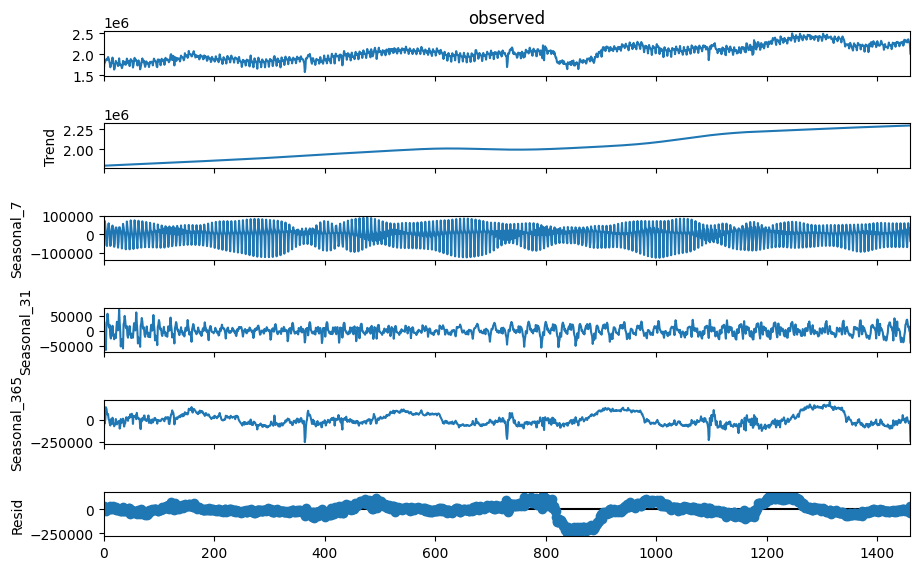

In [65]:
# your code here
# ≽^•⩊•^≼

model = MSTL_decomp(reg['value'],  periods=(7,31,365))
res = model.fit()

fig = res.plot()
fig.set_size_inches(10, 6)
plt.show()

In [66]:
acorr_ljungbox(res.resid, return_df=True)

,lb_stat,lb_pvalue
1,1319.881169,5.404928e-289
2,2608.569848,0.000000e+00
3,3887.610305,0.000000e+00
4,5160.565604,0.000000e+00
5,6403.904177,0.000000e+00
6,7637.221993,0.000000e+00
7,8824.677428,0.000000e+00
8,10001.813234,0.000000e+00
9,11154.929052,0.000000e+00
10,12283.125953,0.000000e+00


Autocorrelated residuals. Let's try smth else

In [67]:
reg['log_value'] = np.log(reg['value'])

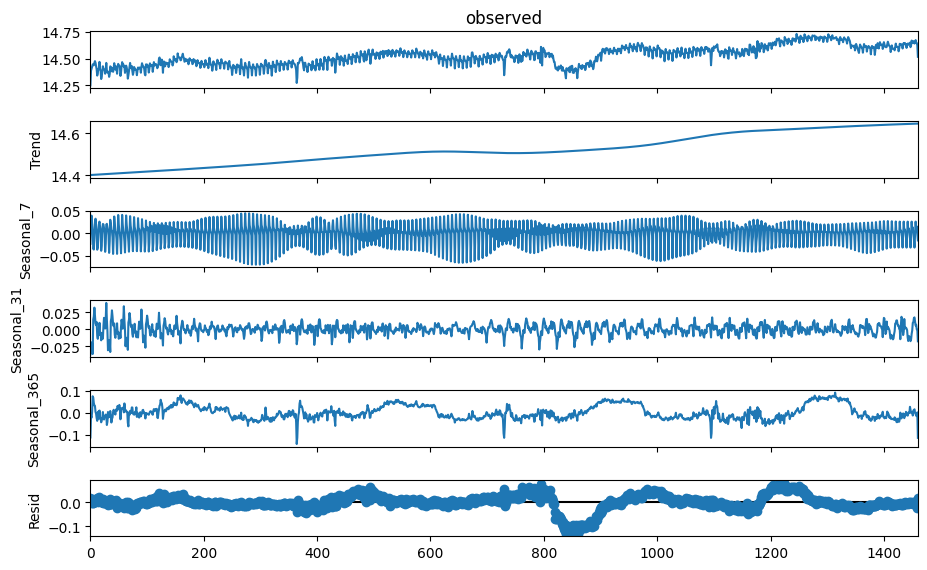

In [99]:
mstl_multi = MSTL_decomp(reg['log_value'], periods=(7,31,365))
res_multi = mstl_multi.fit()

fig = res_multi.plot()
fig.set_size_inches(10, 6)
plt.show()

In [100]:
acorr_ljungbox(res_multi.resid, return_df=True)

,lb_stat,lb_pvalue
1,1315.143977,5.784127e-288
2,2597.366898,0.000000e+00
3,3870.701855,0.000000e+00
4,5138.346184,0.000000e+00
5,6375.816851,0.000000e+00
6,7602.364227,0.000000e+00
7,8779.883793,0.000000e+00
8,9946.377893,0.000000e+00
9,11088.822951,0.000000e+00
10,12206.732425,0.000000e+00


Still autocorrelation.

In [82]:
for i in range(3, 50):
    res_sd = seasonal_decompose(reg['value'],  period=i)
    print('i = ', i)
    print(acorr_ljungbox(res_sd.resid.dropna(), return_df=True))

i =  3
        lb_stat      lb_pvalue
1    272.950182   2.581919e-61
2    355.835610   5.386159e-78
3    399.782427   2.467648e-86
4    434.198866   1.131277e-92
5    513.590640  9.300117e-109
6    596.446238  1.362417e-125
7   1198.450027  1.527899e-254
8   1295.583776  2.117024e-274
9   1361.070311  1.990242e-287
10  1399.847519  1.070165e-294
i =  4
        lb_stat      lb_pvalue
1     51.913893   5.798865e-13
2    408.516717   1.957592e-89
3    449.361365   4.483535e-97
4    491.607075  4.377554e-105
5    706.356411  2.074207e-150
6    722.381930  8.986810e-153
7   1387.742942  1.732350e-295
8   1409.742104  4.430158e-299
9   1600.520143   0.000000e+00
10  1635.776942   0.000000e+00
i =  5
        lb_stat      lb_pvalue
1     11.558871   6.742677e-04
2    488.791051  7.250566e-107
3    516.048054  1.587498e-111
4    553.533576  1.759509e-118
5    816.566519  3.014631e-174
6    820.249169  6.487471e-174
7   1503.934868   0.000000e+00
8   1509.852165   0.000000e+00
9   1748.794836   

I tried to gridsearch it, but all values from 3 to 500 gave autocorrelation.

Let's try to model residuals with ARIMA.

In [83]:
# Fit Auto ARIMA model
model_resid = auto_arima(res.resid, stepwise=True, trace=True)

# Print the summary of the model
print(model_resid.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=32687.485, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=36414.306, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=33026.404, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=35554.104, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=36412.326, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=32686.857, Time=0.87 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=35307.293, Time=0.33 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=32686.847, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=32687.561, Time=1.37 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=32817.839, Time=0.43 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=32684.850, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=35552.122, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=33024.407, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=32685.563, Time=2.05 sec
 ARIMA(1,0,2)(0,0,0

In [84]:
# ARIMA models
from statsmodels.tsa.arima.model import ARIMA

In [85]:
model_arima = ARIMA(res.resid, order=(1,0,1))
model_arima = model_arima.fit()

In [86]:
resid_arima = model_arima.resid

In [88]:
acorr_ljungbox(resid_arima, return_df=True)

,lb_stat,lb_pvalue
1,0.326539,5.677042e-01
2,7.494113,2.358708e-02
3,7.496303,5.765353e-02
4,19.981491,5.036184e-04
5,20.440194,1.032964e-03
6,39.605712,5.444365e-07
7,44.943383,1.402650e-07
8,48.098160,9.461671e-08
9,51.595341,5.390727e-08
10,56.256538,1.837811e-08


Still autocorrelation :(

In [90]:
for i in [5, 20, 252]:
    res_sd = seasonal_decompose(reg['value'],  period=i)
    print('i = ', i)
    print(acorr_ljungbox(res_sd.resid.dropna(), return_df=True))

i =  5
        lb_stat      lb_pvalue
1     11.558871   6.742677e-04
2    488.791051  7.250566e-107
3    516.048054  1.587498e-111
4    553.533576  1.759509e-118
5    816.566519  3.014631e-174
6    820.249169  6.487471e-174
7   1503.934868   0.000000e+00
8   1509.852165   0.000000e+00
9   1748.794836   0.000000e+00
10  1774.450815   0.000000e+00
i =  20
       lb_stat      lb_pvalue
1   103.049298   3.269114e-24
2   147.295337   1.035676e-32
3   158.055934   4.815679e-34
4   182.839017   1.831367e-38
5   323.054583   1.102422e-67
6   324.253734   5.166941e-67
7   590.406232  2.833497e-123
8   596.106305  1.607937e-123
9   773.473813  1.087787e-160
10  819.993226  1.037267e-169
i =  252
        lb_stat      lb_pvalue
1    714.455431  2.149419e-157
2   1284.031721  1.499873e-279
3   1926.157903   0.000000e+00
4   2529.563635   0.000000e+00
5   3005.350377   0.000000e+00
6   3507.324408   0.000000e+00
7   4203.341660   0.000000e+00
8   4649.586265   0.000000e+00
9   5041.447806   0.000000

❓ **Why have you chosen this decomposition method and such lengths for seasonal period/periods? Write your comments below:**

I decided to choose MSTL decomposition because it has the most values of ljungbox test.

🐍 **Analyze residuals for autotocorrelation (with 1 test) and stationarity (with 2 tests).**

In [101]:
# your code here
# ≽^•⩊•^≼
acorr_ljungbox(res.resid, return_df=True)

,lb_stat,lb_pvalue
1,1319.881169,5.404928e-289
2,2608.569848,0.000000e+00
3,3887.610305,0.000000e+00
4,5160.565604,0.000000e+00
5,6403.904177,0.000000e+00
6,7637.221993,0.000000e+00
7,8824.677428,0.000000e+00
8,10001.813234,0.000000e+00
9,11154.929052,0.000000e+00
10,12283.125953,0.000000e+00


In [103]:
adf_test(res.resid)

Results of Dickey-Fuller Test:
Test Statistic                   -3.955903
p-value                           0.001660
#Lags Used                       23.000000
Number of Observations Used    1437.000000
Critical Value (1%)              -3.434909
Critical Value (5%)              -2.863553
Critical Value (10%)             -2.567842
dtype: float64


In [104]:
kpss_test(res.resid)

Results of KPSS Test:
Test Statistic            0.070779
p-value                   0.100000
Lags Used                25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


❓ **Is your decomposition successful based on the residuals? What may be the reasons for such a result? Write your comments below:**

We can see that our residuals are stationary (based on 2 tests) and autocorrelated. This is a common case in real data.

🐍 **Save the trend component from your decomposition to trend_reg variable.**

In [107]:
trend_reg = res.trend

With the code below, you can see how *DAU trend* regressor "correlates" with *views* time series.

In [108]:
import plotly.graph_objects as go

# Create an empty fig
fig = go.Figure()

# Add y graph on the left
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['y'],
    mode='lines',
    name='y',
    line=dict(color='blue'),
    yaxis='y1'  # Tie to y1
))

# Add x graph on the right
fig.add_trace(go.Scatter(
    x=trend_reg.index,
    y=trend_reg,
    mode='lines',
    name='net income',
    line=dict(color='red'),
    yaxis='y2'  # Tie to y1
))


fig.update_layout(
    title="BookBnb views for listings from Kaliningrad, daily",
    template='plotly_white',
    width=1000,
    height=500,
    yaxis=dict(
        title='stock prices',
    ),
    yaxis2=dict(
        title='net income',
        overlaying='y',  # Impose axes
        side='right'
    ),
    xaxis=dict(title='Date')
)

fig.show()

### Task 2.2.2 - Trend forecasting with Auto-ARIMAX (1 point)

After isolating the trend component of DAU, the next step is to model and forecast this trend for future dates.

Since trends often exhibit autocorrelation and gradual shifts over time, a statistical model like Auto-ARIMA is well-suited for this task.

As far as most businesse have been influenced by COVID-19, you should also add your COVID dummy regressor and build Auto-ARIMAX model.

🐍 **Build Auto-ARIMAX model (from ```pmdarima```), which takes COVID regressor into consideration.**

In [112]:
regressors.head()

,ds,covid,new_feature
0,2019-01-01,0,0
1,2019-01-02,0,0
2,2019-01-03,0,0
3,2019-01-04,0,0
4,2019-01-05,0,0


In [115]:
trend_reg

,trend
0,1.794579e+06
1,1.794889e+06
2,1.795198e+06
3,1.795508e+06
4,1.795818e+06
...,...
1456,2.299323e+06
1457,2.299550e+06
1458,2.299778e+06
1459,2.300004e+06


In [119]:
# your code here
# ≽^•⩊•^≼

model = auto_arima(trend_reg, X=regressors[['covid']], stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14738.841, Time=10.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20015.776, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11569.887, Time=0.85 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20005.443, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21749.616, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11562.355, Time=2.86 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=14582.105, Time=2.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14872.060, Time=4.78 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11563.931, Time=11.80 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=14851.842, Time=11.87 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=inf, Time=10.75 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 56.904 seconds


❓ **How does auto-ARIMA choose proper orders (p,d,q)? Write your comments below:**

Auto-ARIMA selects orders (p, d, q) by testing different combinations using statistical criteria like AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion) to minimize error and optimize model performance.

Let's see the summary of the model.

In [120]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1461
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -5776.178
Date:                Sun, 29 Dec 2024   AIC                          11562.355
Time:                        15:58:13   BIC                          11588.786
Sample:                             0   HQIC                         11572.215
                               - 1461                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8006      0.143     19.576      0.000       2.520       3.081
covid          0.0110      5.485      0.002      0.998     -10.740      10.762
ar.L1          0.9290      0.010     95.810      0.0

\❓ **Write the equation for the built Auto-ARIMAX model based on the summary:**

$Y_t = \mu + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \beta X_t + \varepsilon_t - \varepsilon_{t-1}$


🐍 **Make out-of-sample forecast for future FORECAST_HORIZON dates.**

In [121]:
# your code here
# ≽^•⩊•^≼

trend_forecast = model.predict(n_periods=FORECAST_HORIZON, X=regressors_future[['covid']])

print(trend_forecast)

1461    2.300457e+06
1462    2.300684e+06
1463    2.300910e+06
1464    2.301137e+06
1465    2.301364e+06
            ...     
1821    2.382406e+06
1822    2.382634e+06
1823    2.382862e+06
1824    2.383090e+06
1825    2.383318e+06
Length: 365, dtype: float64


Let's plot the trend and its Auto-ARIMA forecast.

In [123]:
fig = px.line(title="BookBnb DAU trend, daily")
fig.add_scatter(x=trend_reg.index, y=trend_reg, mode='lines', name='DAU', line=dict(color='blue'))
fig.add_scatter(x=trend_forecast.index, y=trend_forecast, mode='lines', name='DAU forecast', line=dict(color='red'))

fig.update_layout(template='plotly_white', width=800, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="DAU")
fig.show()

In [131]:
trend_forecast

,0
1461,2.300457e+06
1462,2.300684e+06
1463,2.300910e+06
1464,2.301137e+06
1465,2.301364e+06
...,...
1821,2.382406e+06
1822,2.382634e+06
1823,2.382862e+06
1824,2.383090e+06


In [136]:
trend_forecast = trend_forecast.reset_index(drop=True)
trend_forecast

,0
0,2.300457e+06
1,2.300684e+06
2,2.300910e+06
3,2.301137e+06
4,2.301364e+06
...,...
360,2.382406e+06
361,2.382634e+06
362,2.382862e+06
363,2.383090e+06


🐍 **Add *trend_reg* to *regressors* dataframe and *trend_forecast* to *regressors_future* dataframe.**

In [137]:
# your code here
# ≽^•⩊•^≼

regressors['DAU'] = trend_reg
regressors_future['DAU'] = trend_forecast

In [138]:
# Check if everything is ok

assert len(regressors.columns) == 4
assert len(regressors_future.columns) == 4

assert regressors.isna().sum().sum() == 0
assert regressors_future.isna().sum().sum() == 0

## Prepare train-test

Now we can move to preparing our dataset for the forecasting models.

🐍 **Add prepared regressors to initial time series.** Forecasting models, you'll be working today with, expect to have regressors in columns.

In [139]:
df.head()

,region,ds,metric,y
0,Kaliningrad,2019-01-01,views,26011.0
1,Kaliningrad,2019-01-02,views,23158.0
2,Kaliningrad,2019-01-03,views,23413.0
3,Kaliningrad,2019-01-04,views,22534.0
4,Kaliningrad,2019-01-05,views,21431.0


In [141]:
regressors.head()

,ds,covid,new_feature,DAU
0,2019-01-01,0,0,1.794579e+06
1,2019-01-02,0,0,1.794889e+06
2,2019-01-03,0,0,1.795198e+06
3,2019-01-04,0,0,1.795508e+06
4,2019-01-05,0,0,1.795818e+06


In [143]:
# your code here
# ≽^•⩊•^≼

df_with_reg = pd.merge(df, regressors, on='ds', how='left')
df_with_reg.head()

,region,ds,metric,y,covid,new_feature,DAU
0,Kaliningrad,2019-01-01,views,26011.0,0,0,1.794579e+06
1,Kaliningrad,2019-01-02,views,23158.0,0,0,1.794889e+06
2,Kaliningrad,2019-01-03,views,23413.0,0,0,1.795198e+06
3,Kaliningrad,2019-01-04,views,22534.0,0,0,1.795508e+06
4,Kaliningrad,2019-01-05,views,21431.0,0,0,1.795818e+06


Let's split *views* time series into train/test: 2019-2021 for train and 2022 - for test

🐍 **Split target time series into train/test: 2019-2021 for train and 2022 - for test. Define the forecasting horizon.**

In [ ]:
train = df[df['ds'] < '2022-01-01']  # Данные до 2022 года
test = df[df['ds'] >= '2022-01-01'] # Данные начиная с 2022 года

# Просмотр размеров выборок
print(f'Train size: {len(train)}, Test size: {len(test)}')

# Просмотр первых строк
print(train.head())
print(test.head())

In [144]:
df[df['ds'] < '2022-01-01'].shape

(1096, 4)

In [151]:
# your code here
# ≽^•⩊•^≼

train_size = 1096
train, test = df_with_reg[:train_size], df_with_reg[train_size:]

In [152]:
# your code here
# ≽^•⩊•^≼

forecast_horizon = FORECAST_HORIZON
forecast_horizon

365

In [153]:
# Check if everything is ok

assert train.shape == (1096, 7)
assert test.shape == (365, 7)

Let's plot train/test split.

In [154]:
fig = px.line(title="train-test")
fig.add_scatter(x=train['ds'], y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines', name='test', line=dict(color='green'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

# 3 - Prophet model

Finally, we can move to the models. To forecast *views* time series, we will use the Prophet model. Prophet is a ML forecasting tool designed to work effectively with time series data that exhibits seasonality, trends and holiday effects.

However, before you start you should choose a proper quality metric.

## Task 3.1 - Quality metric choice (0.5 points)

❓ **What quality metric have you chosen for the task? Why? Write your comments below:**

I prefer RMSE for penalizing large errors.

## Task 3.2 - Prophet model

Further, you should add holidays and regressors to your model. Prophet treats both of these components separately and adding them might enhance your forecast.

### Task 3.2.1 - Holidays & Regressors (0.5 point)

\🐍 **Prepare *holidays_df* dataframe to account for holidays in your Prophet model.**

In [155]:
# Here's a dict of Russian holidays you should take into account

russian_holidays = {
    "New Year": "01-01",
    "Christmas": "01-07",
    "Defender of the Fatherland Day": "02-23",
    "International Women's Day": "03-08",
    "Spring and Labour Day": "05-01",
    "Victory Day": "05-09",
    "Day of Russia": "06-12",
    "National Unity Day": "11-04"
}

In [156]:
dates = []
holidays = []

for year in pd.date_range(start=df.ds.min(), end=df.ds.max(), freq='YS'):
  for holiday in russian_holidays.keys():
    dates.append(str(year.year)+'-'+russian_holidays[holiday])
    holidays.append(holiday)

In [161]:
# your code here
# ≽^•⩊•^≼

holidays_df = pd.DataFrame({
    'ds': pd.to_datetime(dates),
    'holiday': holidays
})

print(holidays_df)

           ds                         holiday
0  2019-01-01                        New Year
1  2019-01-07                       Christmas
2  2019-02-23  Defender of the Fatherland Day
3  2019-03-08       International Women's Day
4  2019-05-01           Spring and Labour Day
5  2019-05-09                     Victory Day
6  2019-06-12                   Day of Russia
7  2019-11-04              National Unity Day
8  2020-01-01                        New Year
9  2020-01-07                       Christmas
10 2020-02-23  Defender of the Fatherland Day
11 2020-03-08       International Women's Day
12 2020-05-01           Spring and Labour Day
13 2020-05-09                     Victory Day
14 2020-06-12                   Day of Russia
15 2020-11-04              National Unity Day
16 2021-01-01                        New Year
17 2021-01-07                       Christmas
18 2021-02-23  Defender of the Fatherland Day
19 2021-03-08       International Women's Day
20 2021-05-01           Spring and

Usually, the New Year's effect is present 10 days before and after 1 January.

🐍 **Add lower and upper windows for New Year holiday.**

In [163]:
# your code here
# ≽^•⩊•^≼

dates = []
holidays = []
lower_window = []
upper_window = []

for year in pd.date_range(start=df['ds'].min(), end=df['ds'].max(), freq='YS'):
    for holiday, date in russian_holidays.items():
        dates.append(f"{year.year}-{date}")
        holidays.append(holiday)

        if holiday == "New Year":
            lower_window.append(-10)
            upper_window.append(10)
        else:
            lower_window.append(0)
            upper_window.append(0)

holidays_df = pd.DataFrame({
    'ds': pd.to_datetime(dates),
    'holiday': holidays,
    'lower_window': lower_window,
    'upper_window': upper_window
})

print(holidays_df)


           ds                         holiday  lower_window  upper_window
0  2019-01-01                        New Year           -10            10
1  2019-01-07                       Christmas             0             0
2  2019-02-23  Defender of the Fatherland Day             0             0
3  2019-03-08       International Women's Day             0             0
4  2019-05-01           Spring and Labour Day             0             0
5  2019-05-09                     Victory Day             0             0
6  2019-06-12                   Day of Russia             0             0
7  2019-11-04              National Unity Day             0             0
8  2020-01-01                        New Year           -10            10
9  2020-01-07                       Christmas             0             0
10 2020-02-23  Defender of the Fatherland Day             0             0
11 2020-03-08       International Women's Day             0             0
12 2020-05-01           Spring and Lab

In [164]:
# Check if everything is ok
assert holidays_df.shape == (32, 4)

### Task 3.2.2 - Prophet model (0.5 point)

🐍 **Build, train Prophet model (from ```prophet```) with additive weekly seasonality to handle consistent weekly changes and multiplicative yearly seasonality. Add holidays and all of the regressors, considered in part 2. Build forecast.**

In [165]:
train.head()

,region,ds,metric,y,covid,new_feature,DAU
0,Kaliningrad,2019-01-01,views,26011.0,0,0,1.794579e+06
1,Kaliningrad,2019-01-02,views,23158.0,0,0,1.794889e+06
2,Kaliningrad,2019-01-03,views,23413.0,0,0,1.795198e+06
3,Kaliningrad,2019-01-04,views,22534.0,0,0,1.795508e+06
4,Kaliningrad,2019-01-05,views,21431.0,0,0,1.795818e+06


In [171]:
# your code here
# ≽^•⩊•^≼

model_prophet = fp.Prophet(holidays=holidays_df)

model_prophet.add_seasonality(name = 'weekly', fourier_order=3, period=7, mode='additive')
model_prophet.add_seasonality(name = 'yearly', fourier_order=10, period=365, mode='multiplicative')

model_prophet.add_regressor('covid')
model_prophet.add_regressor('new_feature')
model_prophet.add_regressor('DAU')

model_prophet.fit(train)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7jjqv85c/9sk7nnyl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7jjqv85c/mk_4ab9q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29160', 'data', 'file=/tmp/tmp7jjqv85c/9sk7nnyl.json', 'init=/tmp/tmp7jjqv85c/mk_4ab9q.json', 'output', 'file=/tmp/tmp7jjqv85c/prophet_model_5n420yb/prophet_model-20241229165812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:58:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:58:13 - cmdstanpy - INFO - Chain [1] done proc

In [177]:
# Build forecast
forecast_prophet = test[['ds']]
forecast_prophet['covid'] = test[['covid']]
forecast_prophet['new_feature'] = test[['new_feature']]
forecast_prophet['DAU'] = test[['DAU']]
forecast = model_prophet.predict(forecast_prophet)

Plot the forecast.

In [178]:
fig = px.line(title="BookBnb views for listings from Kaliningrad forecast, daily")
fig.add_scatter(x=train['ds'], y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="views")
fig.show()

🐍 **Evaluate your forecast with chosen quality metric.**

In [183]:
# your code here
# ≽^•⩊•^≼
print('RMSE: ', rmse(forecast['yhat'].values, test['y'].values))

RMSE:  4780.4897014471035


Further, use the model with regressors and holidays.

## Task 3.3 - Hyperparameters tuning (1 point)

As a ML forecasting model, Prophet requires accurate hyperparameters tuning. Further, you'll tune hyperparameters with GridSearch + Cross Validation approach.



🐍 **Prepare hyperparameters grid.** Your grid should include parameters for trend, seasonality and holidays.

In [184]:
# your code here
# ≽^•⩊•^≼

param_grid = {
    'changepoint_prior_scale': [0.05,0.1,0.5],
    'seasonality_prior_scale': [0.001,0.1,10.0],
    'seasonality_mode':['multiplicative','additive'],
    'holidays_prior_scale':[1.0,5.0,10.0]
}

# Create all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

len(all_params)

54

🐍 **Perform GridSearch + Cross Validation.**

In [185]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import add_changepoints_to_plot

from tqdm import tqdm

In [186]:
# your code here
# ≽^•⩊•^≼
mapes = []

# Cross validation
for params in tqdm(all_params):
    m = fp.Prophet(**params, holidays=holidays_df)
    m.add_regressor('covid')
    m.add_regressor('new_feature')
    m.add_regressor('DAU')
    m.fit(train)
    df_cv = cross_validation(m, initial='365.25 days', period='180 days', horizon = '180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    mapes.append(df_p['mape'].values[0])

  0%|          | 0/54 [00:00<?, ?it/s]INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7jjqv85c/05mt0ixu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7jjqv85c/xjsny5cw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69851', 'data', 'file=/tmp/tmp7jjqv85c/05mt0ixu.json', 'init=/tmp/tmp7jjqv85c/xjsny5cw.json', 'output', 'file=/tmp/tmp7jjqv85c/prophet_modellgrd7l_2/prophet_model-20241229173802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:38:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:38:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 4 forecasts with cutoffs between 2020-01-11 00:00:00 and 2021-07-04 00:00:00
INFO:pr

🐍 **Extract hyperparameters which provide the best quality.**

In [188]:
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes

In [189]:
# your code here
# ≽^•⩊•^≼

best_params = all_params[tuning_results.sort_values(by='mape').index[0]]
best_params

{'changepoint_prior_scale': 0.05,
 'seasonality_prior_scale': 0.1,
 'seasonality_mode': 'multiplicative',
 'holidays_prior_scale': 1.0}

🐍 **Build, train and forecast with tuned Prophet model.**

In [191]:
# your code here
# ≽^•⩊•^≼

model_prophet_tuned = fp.Prophet(changepoint_prior_scale= 0.05,
 seasonality_prior_scale= 0.1,
 seasonality_mode='multiplicative',
 holidays_prior_scale= 1.0, holidays=holidays_df)

model_prophet_tuned.add_seasonality(name = 'weekly', fourier_order=3, period=7, mode='additive')
model_prophet_tuned.add_seasonality(name = 'yearly', fourier_order=10, period=365, mode='multiplicative')

model_prophet_tuned.add_regressor('covid')
model_prophet_tuned.add_regressor('new_feature')
model_prophet_tuned.add_regressor('DAU')

model_prophet_tuned.fit(train)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7jjqv85c/n8s4ly85.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7jjqv85c/0wg9wv9o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62247', 'data', 'file=/tmp/tmp7jjqv85c/n8s4ly85.json', 'init=/tmp/tmp7jjqv85c/0wg9wv9o.json', 'output', 'file=/tmp/tmp7jjqv85c/prophet_model11o1y26k/prophet_model-20241229174659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:46:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:00 - cmdstanpy - INFO - Chain [1] done proc

In [192]:
# Build forecast
forecast_prophet_tuned = test[['ds']]
forecast_prophet_tuned['covid'] = test[['covid']]
forecast_prophet_tuned['new_feature'] = test[['new_feature']]
forecast_prophet_tuned['DAU'] = test[['DAU']]
forecast_tuned = model_prophet_tuned.predict(forecast_prophet_tuned)

Plot forecast.

In [193]:
fig = px.line(title="BookBnb views for listings from Kaliningrad forecast, daily")
fig.add_scatter(x=train['ds'], y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast_tuned['ds'], y=forecast_tuned['yhat'], mode='lines', name='forecast', line=dict(color='violet'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="views")
fig.show()

🐍 **Evaluate your forecast with chosen quality metric.**

In [194]:
# your code here
# ≽^•⩊•^≼
print('RMSE: ', rmse(forecast_tuned['yhat'].values, test['y'].values))

RMSE:  4386.237313267275


# 4 - MSTL model

Now let's move to the MSTL (Multiplicative Seasonal-Trend Decomposition using LOESS), a statistical forecasting model. In this part, you will use MSTL as a forecasting tool.

## Task 4.1 - MSTL model (1 point)

🐍 **Build, train and forecast with MSTL model (from

---

```statsforecast```)  with regressors, discussed in part 2.**

In [196]:
from statsforecast.models import AutoARIMA

In [213]:
# your code here
# ≽^•⩊•^≼
models = [
    MSTL(
        season_length=[7, 31, 365], # define seasonal periods
        trend_forecaster=AutoARIMA()
        # (method='CSS-ML') # there can be different models, but let's use AutoARIMA for now
        )
]

sf = StatsForecast(models=models, freq='D', n_jobs=-1)

❓ **Why have you chosen such lengths for seasonal period/periods? Write your comments below:**

I chose common values because during trend extranction I haven't reach any reasonable results.

In [214]:
train.head()

,region,ds,metric,y,covid,new_feature,DAU,unique_id
0,Kaliningrad,2019-01-01,views,26011.0,0,0,1.794579e+06,hi
1,Kaliningrad,2019-01-02,views,23158.0,0,0,1.794889e+06,hi
2,Kaliningrad,2019-01-03,views,23413.0,0,0,1.795198e+06,hi
3,Kaliningrad,2019-01-04,views,22534.0,0,0,1.795508e+06,hi
4,Kaliningrad,2019-01-05,views,21431.0,0,0,1.795818e+06,hi


In [215]:
train['unique_id'] = 'hi'
test['unique_id'] = 'hi'

In [216]:
test.head()

,region,ds,metric,y,covid,new_feature,DAU,unique_id
1096,Kaliningrad,2022-01-01,views,35224.0,1,1,2.176243e+06,hi
1097,Kaliningrad,2022-01-02,views,36810.0,1,1,2.177059e+06,hi
1098,Kaliningrad,2022-01-03,views,38243.0,1,1,2.177869e+06,hi
1099,Kaliningrad,2022-01-04,views,38403.0,1,1,2.178673e+06,hi
1100,Kaliningrad,2022-01-05,views,35848.0,1,1,2.179470e+06,hi


In [217]:
train_mstl = train[['ds', 'y', 'covid', 'new_feature', 'DAU', 'unique_id']]
test_mstl = test[['ds', 'covid', 'new_feature', 'DAU', 'unique_id']]
# X_train = train[['covid', 'new_feature', 'DAU']]
# X_test = test[['covid', 'new_feature', 'DAU']]

In [218]:
# Build forecast
forecast_mstl = sf.forecast(df=train_mstl, X_df = test_mstl, h=forecast_horizon)

In [221]:
forecast_mstl

,unique_id,ds,MSTL
0,hi,2022-01-01,24090.780860
1,hi,2022-01-02,26441.860422
2,hi,2022-01-03,27270.992392
3,hi,2022-01-04,26402.628788
4,hi,2022-01-05,25726.424987
...,...,...,...
360,hi,2022-12-27,18718.996759
361,hi,2022-12-28,17825.990060
362,hi,2022-12-29,14030.662568
363,hi,2022-12-30,12155.025315


In [219]:
fig = px.line(title="BookBnb views for listings from Kaliningrad forecast, daily")
fig.add_scatter(x=train['ds'], y=(train['y']), mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast_mstl['ds'], y=(forecast_mstl['MSTL']), mode='lines', name='forecast', line=dict(color='red'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="views")
fig.show()

🐍 **Evaluate your forecast with chosen quality metric.**

In [222]:
# your code here
# ≽^•⩊•^≼
print('RMSE: ', rmse(forecast_mstl['MSTL'].values, test['y'].values))

RMSE:  16159.582513682719


# 5 - Comparison of models

As you've built 2 different models, it's now time to choose the best one. For this, you should perform Cross Validation (CV) to evaluate your model properly. Note, that if you use different libraries for Cross Validation, it's vital to obtain similar cutoffs for your models.

## Task 5.1 - Evaluate your best Prophet model with CV (1 point)

In [279]:
# your code here
# ≽^•⩊•^≼

df_cv_prophet = cross_validation(model_prophet_tuned, initial='540 days', period='90 days', horizon = '180 days', parallel="processes")

INFO:prophet:Making 5 forecasts with cutoffs between 2020-07-09 00:00:00 and 2021-07-04 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7e39cd054400>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7jjqv85c/hezcru71.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7jjqv85c/1ae94c3l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7jjqv85c/296ldifm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7jjqv85c/vy95b2cf.json
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70288', 'data', 'file=/tmp/tmp7jjqv85c/hezcru71.json', 'init=/tmp/tmp7jjqv85c/296ldifm.json', 'output', 'file=/tmp/tmp7jjqv85c/prophet_model85ku3svb/prophet_model-20241229194446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
INFO:cmdstanpy:Chain [1] start processing
19:44:46 - cmdstanpy - INFO - Chain [1] start processing
DEB

In [280]:
cv_metrics_prophet = performance_metrics(df_cv, rolling_window = 1)

In [281]:
cv_metrics_prophet

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,180 days,1.409771e+08,11873.377482,9523.153407,0.32005,0.221926,0.250636,0.193056


In [282]:
df_cv_prophet.cutoff.unique()

<DatetimeArray>
['2020-07-09 00:00:00', '2020-10-07 00:00:00', '2021-01-05 00:00:00',
 '2021-04-05 00:00:00', '2021-07-04 00:00:00']
Length: 5, dtype: datetime64[ns]

## Task 5.3 - Evaluate your best MSTL models with CV  (1 point)

In [263]:
from utilsforecast.losses import rmse, mae, mape

In [283]:
# your code here
# ≽^•⩊•^≼

df_cv_mstl = sf.cross_validation(
    df=train_mstl,
    h=180,                # horizon = 180 days
    step_size=90,         # period = 30 days
    n_windows=5        # match the number of cutoffs (19 windows)
).reset_index()

In [284]:
df_cv_mstl.cutoff.unique()

<DatetimeArray>
['2020-07-09 00:00:00', '2020-10-07 00:00:00', '2021-01-05 00:00:00',
 '2021-04-05 00:00:00', '2021-07-04 00:00:00']
Length: 5, dtype: datetime64[ns]

In [285]:
cv_metrics_mstl = rmse(df_cv_mstl, models=['MSTL'], target_col='y')['MSTL'].item()
print(f"RMSE: {cv_metrics_mstl:.2f}")

RMSE: 4957.32


In [286]:
cv_metrics_mstl = mae(df_cv_mstl, models=['MSTL'], target_col='y')['MSTL'].item()
print(f"MAE: {cv_metrics_mstl:.2f}")

MAE: 3615.58


In [287]:
cv_metrics_mstl = mape(df_cv_mstl, models=['MSTL'], target_col='y')['MSTL'].item()
print(f"MAPE: {cv_metrics_mstl:.2f}")

MAPE: 0.10


In [288]:
# Check if everything is ok

assert list(df_cv_prophet.cutoff.unique()) == list(df_cv_mstl.cutoff.unique())

## Task 5.4 - The best model (0.5 points)

❓ **Why have you chosen such parameters for your Cross Validations? Write your comments below:**

I chose horizon = 180 days because we have multiple years recorded in data so it's quiet natural value to choose, period is chosen as horizon divided by 2, initial data is chose as horizon multiplied by 3 (default values).

❓ **Which model is the best? How have you chosen the best model? Why this particular model might have been chosen as the best one? Write your comments below:**

Surprisingly, MSTL model has better RMSE results on cross-validation than Prophet model, however in test samples we see the opposite picture. Generally test samples are quiet different from train ones, so I suppose Prophet model catches the main trend in data, though it has worse cv scores.

# 6 - Forecasts

Finally, after the model has been tested and proved to be great,we're ready to provide forecast for the future year.

## Task 6.1 - Out-of-sample forecasts with the best model (1 point)

🐍 **Train your best forecasting model on the full time series. Build out-of-sample forecast for 1 future year.**

In [290]:
daterange = pd.date_range(start=test['ds'].max()+ np.timedelta64(1, 'D'), periods=FORECAST_HORIZON)

In [291]:
daterange

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08',
               '2023-01-09', '2023-01-10',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', length=365, freq='D')

In [292]:
test.head()

,region,ds,metric,y,covid,new_feature,DAU,unique_id
1096,Kaliningrad,2022-01-01,views,35224.0,1,1,2.176243e+06,hi
1097,Kaliningrad,2022-01-02,views,36810.0,1,1,2.177059e+06,hi
1098,Kaliningrad,2022-01-03,views,38243.0,1,1,2.177869e+06,hi
1099,Kaliningrad,2022-01-04,views,38403.0,1,1,2.178673e+06,hi
1100,Kaliningrad,2022-01-05,views,35848.0,1,1,2.179470e+06,hi


In [295]:
df_with_reg.head()

,region,ds,metric,y,covid,new_feature,DAU
0,Kaliningrad,2019-01-01,views,26011.0,0,0,1.794579e+06
1,Kaliningrad,2019-01-02,views,23158.0,0,0,1.794889e+06
2,Kaliningrad,2019-01-03,views,23413.0,0,0,1.795198e+06
3,Kaliningrad,2019-01-04,views,22534.0,0,0,1.795508e+06
4,Kaliningrad,2019-01-05,views,21431.0,0,0,1.795818e+06


In [300]:
train_all = df_with_reg[['ds', 'y', 'covid', 'new_feature', 'DAU']]

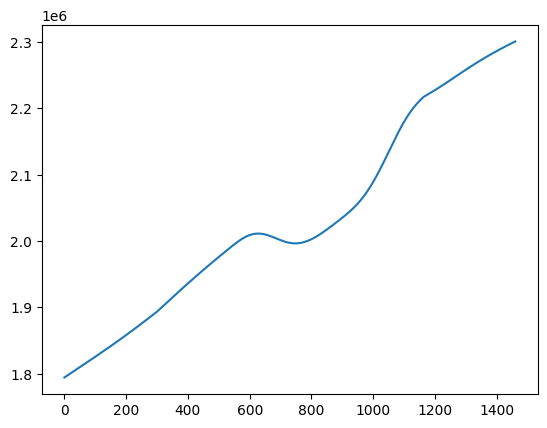

In [298]:
plt.plot(df_with_reg['DAU'])

We have already predicted DAU values for the next year.

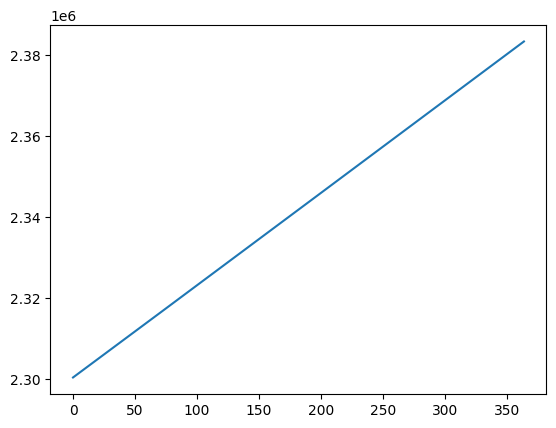

In [299]:
plt.plot(trend_forecast)

In [301]:
X_future = pd.DataFrame()
X_future['ds'] = daterange
X_future['covid'] = np.random.choice([0, 1], size=365, p=[0.7, 0.3])
X_future['new_feature'] = 1
X_future['DAU'] = trend_forecast

X_future.head()


,ds,covid,new_feature,DAU
0,2023-01-01,1,1,2.300457e+06
1,2023-01-02,0,1,2.300684e+06
2,2023-01-03,1,1,2.300910e+06
3,2023-01-04,0,1,2.301137e+06
4,2023-01-05,0,1,2.301364e+06


In [302]:
# your code here
# ≽^•⩊•^≼

best_model = fp.Prophet(changepoint_prior_scale= 0.05,
 seasonality_prior_scale= 0.1,
 seasonality_mode='multiplicative',
 holidays_prior_scale= 1.0, holidays=holidays_df)

best_model.add_seasonality(name = 'weekly', fourier_order=3, period=7, mode='additive')
best_model.add_seasonality(name = 'yearly', fourier_order=10, period=365, mode='multiplicative')

best_model.add_regressor('covid')
best_model.add_regressor('new_feature')
best_model.add_regressor('DAU')

best_model.fit(train_all)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7jjqv85c/4e2dv3jf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7jjqv85c/fm3r350r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22030', 'data', 'file=/tmp/tmp7jjqv85c/4e2dv3jf.json', 'init=/tmp/tmp7jjqv85c/fm3r350r.json', 'output', 'file=/tmp/tmp7jjqv85c/prophet_modelnawtoh36/prophet_model-20241229201421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:14:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:14:23 - cmdstanpy - INFO - Chain [1] done proc

In [303]:
# Build forecast
forecast_future = best_model.predict(X_future)

Plot forecast.

In [304]:
fig = px.line(title="BookBnb views for listings from Kaliningrad forecast, daily")
fig.add_scatter(x=train['ds'], y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test['ds'], y=test['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast_future['ds'], y=forecast_future['yhat'], mode='lines', name='forecast', line=dict(color='violet'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="views")
fig.show()

**That's the end, congratulations** ٩(⁎❛ᴗ❛⁎)۶